In [33]:
import random
import matplotlib.pyplot as plt

class Location:
    def __init__(self, infection_rate):
        self.infection_rate = infection_rate

class Person:
    def __init__(self, location, infected=False):
        self.location = location
        self.infected = infected
        self.recovery_prob = 0.1

def pairs(lst):
    for i, item1 in enumerate(lst):
        for item2 in lst[i+1:]:
            yield item1, item2

def infection_pairs(people):
    for person1, person2 in pairs(people):
        if person1.location == person2.location:
            if person1.infected and not person2.infected:
                yield person1, person2
            elif person2.infected and not person1.infected:
                yield person2, person1
                
def find_new_infections(people):
    new_infections = []
    for person1, person2 in infection_pairs(people):
        if random.random() < person1.location.infection_rate and person2 not in new_infections:
            new_infections.append(person2)
    return new_infections

def count_infected(people):
    return sum(person.infected for person in people)

def simulate(people, locations, num_days):
    results = []
    for day in range(num_days):
        # Infection
        for person in find_new_infections(people):
            person.infected = True
        # Recovery
        for person in people:
            if person.infected and random.random() < person.recovery_prob:
                person.infected = False
        # Track number of infected people
        results.append(count_infected(people))
    return results

def plot_results(results, num_days):
    fig, axes = plt.subplots()
    axes.plot(results)

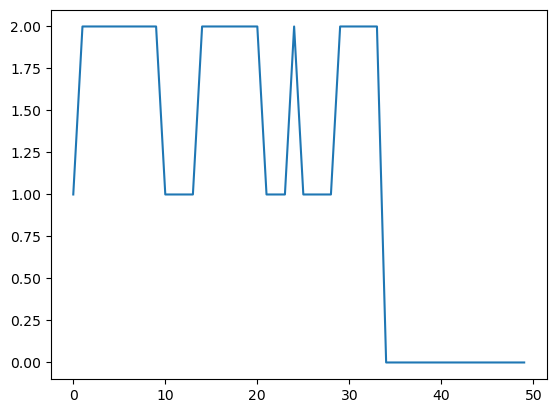

In [42]:
locations = [Location(0.2)]
people = [Person(locations[0], True), Person(locations[0])]
num_days = 50
results = simulate(people, locations, num_days)
plot_results(results, num_days)